In [531]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [532]:
# Define some arbitrary constants for our equations

NUTRIENT_INTAKE_RATE = 0.5
LITTERING_RATE = 0.3
WFPS = 1
L2 = lambda x: x
W = lambda t: WFPS

In [533]:
def F(t, x):
    x_0 = LITTERING_RATE*x[1] - L2(W(t))*x[0]
    x_1 = NUTRIENT_INTAKE_RATE*x[1]*x[2] - LITTERING_RATE*x[1]
    x_2 = L2(W(t))*x[0] - NUTRIENT_INTAKE_RATE*x[1]*x[2]
    
    return [x_0, x_1, x_2]
    
t_eval = np.arange(0, 100, 0.01)
sol = solve_ivp(F, [0, 100], [0.5, 0.5, 0.0], t_eval=t_eval)

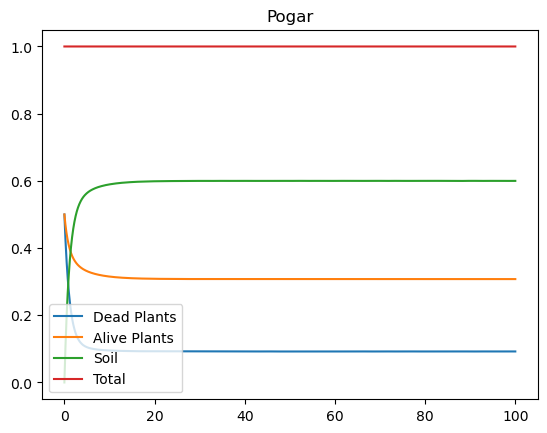

In [534]:
plt.plot(t_eval, sol.y.T[:, 0], label="Dead Plants")
plt.plot(t_eval, sol.y.T[:, 1], label="Alive Plants")
plt.plot(t_eval, sol.y.T[:, 2], label="Soil")
plt.plot(t_eval, sol.y.T[:, 0]+sol.y.T[:, 1]+sol.y.T[:, 2], label="Total")
plt.title("Pogar")
plt.legend()
plt.show()

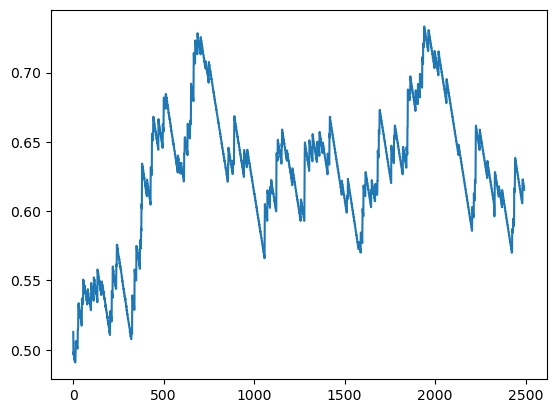

In [647]:
### Define some arbitrary constants for our equations

NUTRIENT_INTAKE_RATE = 0.5
LITTERING_RATE = 0.3
WFPS = 0.3
L2 = lambda x: x

from soil import Waterlist
plt.plot(Waterlist)

W = lambda t: 0.8

In [676]:
from copy import copy, deepcopy

TIME_PERIOD = 1000
SPECIES_COUNT = 20
NUTRIENT_COUNT = 10
FACTOR = 0.001

input_state = np.empty((NUTRIENT_COUNT, SPECIES_COUNT + 2))

np.random.seed(0)

# We now populate our input state
for nutrient in range(NUTRIENT_COUNT):
    for species in range(SPECIES_COUNT):
        input_state[nutrient][species] = np.random.uniform(0.02, 0.08)
        
soil_uptake_params = np.empty((NUTRIENT_COUNT, SPECIES_COUNT))
littering_params = np.empty((NUTRIENT_COUNT, SPECIES_COUNT))
composition = np.empty((NUTRIENT_COUNT, SPECIES_COUNT))

# Populate uptake and littering params
for nutrient in range(NUTRIENT_COUNT):
    for species in range(SPECIES_COUNT):
        soil_uptake_params[nutrient][species] = 45 * FACTOR
        littering_params[nutrient][species] = 20 * FACTOR
        
for species in range(SPECIES_COUNT):
    comp = np.random.uniform(0.1, 1.0, (NUTRIENT_COUNT))
    comp /= sum(comp)
    for nutrient in range(NUTRIENT_COUNT):
        composition[nutrient][species] = comp[nutrient]
        

for nutrient in range(NUTRIENT_COUNT):
    input_state[nutrient][-1] = 0.0 # Start off with zero dead plants
    input_state[nutrient][-2] = 0.2 # Start off with 1-P nutrients in the soil
    

In [677]:
  def F(t, state_space):
    state_space = np.reshape(state_space, (NUTRIENT_COUNT, SPECIES_COUNT + 2))
    return_state = np.empty((NUTRIENT_COUNT, SPECIES_COUNT+2))
    
    # Calculate limiting nutrient in the soil
    limiting_nutrients = [0] * SPECIES_COUNT
    for species in range(SPECIES_COUNT):
        limiting_nutrient = 0
        min_value = state_space[0][-2] / composition[0][species]
        
        for nutrient in range(NUTRIENT_COUNT):
            if state_space[nutrient][-2]/ composition[nutrient][species] < min_value:
                limiting_nutrient = nutrient
                min_value = state_space[nutrient][-2]/ composition[nutrient][species]
                
        limiting_nutrients[species] = limiting_nutrient
        
    # Calculate Biomass for each species
    biomass = np.empty((SPECIES_COUNT))
    for species in range(SPECIES_COUNT):
        biomass[species] = sum(state_space[:, species])
        # print(biomass[species])
    
    nutrient_uptake_total = np.zeros((NUTRIENT_COUNT))
    littering_total = np.zeros((NUTRIENT_COUNT))
    
    # Calculate plant derivatives
    for nutrient in range(NUTRIENT_COUNT):        
        for species in range(SPECIES_COUNT):
            lim_nut = limiting_nutrients[species]
            
            # Get nutrient uptake
            nutrient_uptake = soil_uptake_params[nutrient][species] * biomass[species] * state_space[lim_nut][species] \
            * (composition[nutrient][species]/composition[lim_nut][species]) * W(t)
            
            # Get littering
            littering = littering_params[nutrient][species] * state_space[nutrient][species]
            
            return_state[nutrient][species] = nutrient_uptake - littering
            
            nutrient_uptake_total[nutrient] += nutrient_uptake
            littering_total[nutrient] += littering
            
            
    # Calculate other derivatives
    for nutrient in range(NUTRIENT_COUNT):
        # Soil
        return_state[nutrient][-2] = L2(W(t))*state_space[nutrient][-1] - nutrient_uptake_total[nutrient]
        
        # Dead
        return_state[nutrient][-1] = littering_total[nutrient] - L2(W(t))*state_space[nutrient][-1]
    
    
    # print(return_state)
    return return_state.flatten()
        
t_eval = np.arange(0, TIME_PERIOD, 0.01)
sol = solve_ivp(F, [0, TIME_PERIOD], input_state.flatten(), t_eval=t_eval)

Text(0, 0.5, 'Relative Biomass')

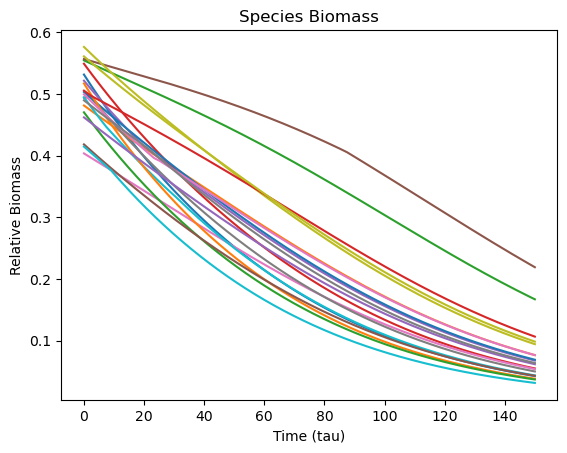

In [678]:
solution = sol.y.reshape((NUTRIENT_COUNT, SPECIES_COUNT+2, sol.y.shape[1]))
for species in range(SPECIES_COUNT):
    plt.plot(t_eval[:15000], np.sum(solution, axis=0)[species, :15000])

plt.title("Species Biomass")
plt.xlabel("Time (tau)")
plt.ylabel("Relative Biomass")

In [656]:
# When (species, nutrients) = (20, 10), AVG_PROD = 0.06007486052228563

# Get average productivity
biomass = np.sum(solution, axis=0)
productivity = np.diff(biomass[:20, :], axis=1)
print(productivity)

[[-7.59855023e-04 -7.58795699e-04 -7.57738635e-04 ... -2.70538072e-90
  -2.69997768e-90 -2.69458546e-90]
 [-3.54319500e-04 -3.54221638e-04 -3.54124338e-04 ... -5.41173236e-90
  -5.40092434e-90 -5.39013797e-90]
 [-2.18324784e-04 -2.18242822e-04 -2.17986353e-04 ... -1.43486428e-89
  -1.43199865e-89 -1.42913875e-89]
 ...
 [-3.78550350e-04 -3.78400662e-04 -3.78251651e-04 ... -5.36094870e-90
  -5.35024210e-90 -5.33955695e-90]
 [-4.21252845e-04 -4.20923866e-04 -4.20596213e-04 ... -7.11895064e-90
  -7.10473305e-90 -7.09054395e-90]
 [-4.33316047e-04 -4.33064186e-04 -4.32812682e-04 ... -2.10890427e-90
  -2.10469248e-90 -2.10048913e-90]]
